
### 1. Importing data


In [1]:
#importing all the important libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
#applying transformation to input image along with defining batch size
transform = transforms.Compose([
    transforms.RandomCrop(32,padding=4),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
Batch_Size = 64

In [3]:
#loading the training and testing MNIST data set
train_data = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform_test)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Batch_Size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Batch_Size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified



### 2. View data 


In [4]:
#printing output class of data
classes=train_data.classes
print(classes)
print(train_data.class_to_idx)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}





### 3. View pictures


In [5]:
#defining a function to show images
def show_data(img):
    #as we have transformed image using normalisation so it will detransform it
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

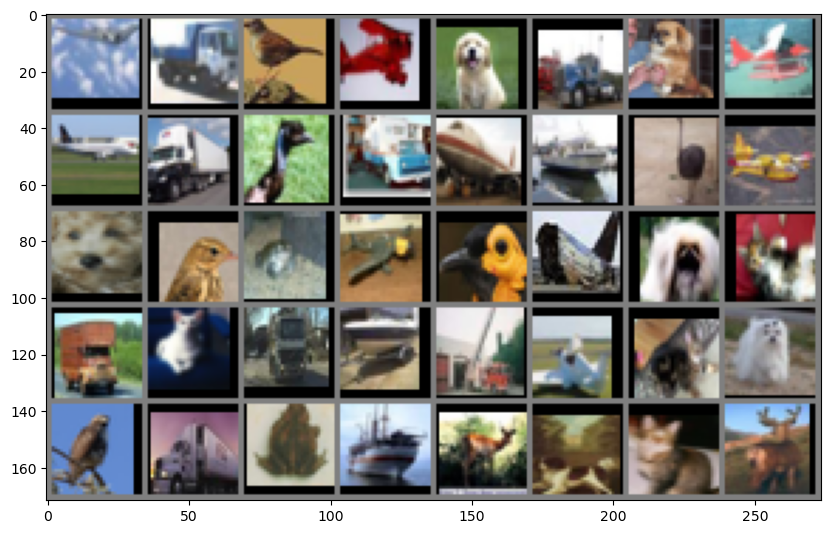

In [6]:
#showing total 40 pictures in grid
im,label = next(iter(train_dataloader))
plt.figure(figsize=(10,12))
show_data(torchvision.utils.make_grid(im[:40]))


### 4. Definition Network Resnet


In [7]:
#setting the device to cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
#This is the code for basic block in the model
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock,self).__init__()
        self.features = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(out_channels),# Normalize the activations from the convolution
                nn.ReLU(True), # Apply ReLU non-linearity
                nn.Conv2d(out_channels,out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(out_channels) # Second batch normalization
            )
            
        # If the input and output dimensions are not equal, use a 1x1 convolutional layer to change the dimension
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels),
            )
    def forward(self, x):
        out = self.features(x) # Process input through the main path
        out += self.shortcut(x)
        out = torch.relu(out) # Final output of the block
        return out

In [9]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, verbose = False,use_dropout=False):
        super(ResNet, self).__init__()
        self.verbose = verbose
         # Initial number of input channels for the first layer after the initial feature layer
        self.in_channels = 64
        #initial configuration before entering into first residual block
        # If dropout is used, include it after the first ReLU activation
        if use_dropout:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64), #  batch normalization
                nn.ReLU(inplace=True),
                nn.Dropout(0.2) #Apllying dropout after activation function
            )
        else:
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True)
            )
             # Layers of residual blocks
        self.layer1 = self.resnet_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.resnet_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.resnet_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.resnet_layer(block, 512, num_blocks[3], stride=2)
         # Final average pooling and classifier block
        self.avg_pool = nn.AvgPool2d(kernel_size=4)
        self.classifer = nn.Linear(512 *block.expansion, num_classes)
        
    def resnet_layer(self, block, out_channels, num_blocks, stride):
        # The first block needs to be downsampled
        strides = [stride] + [1]* (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.features(x)
        if self.verbose:
            print('block 1 output: {}'.format(out.shape))
        out = self.layer1(out)
        if self.verbose:
            print('block 2 output: {}'.format(out.shape))
        out = self.layer2(out)
        if self.verbose:
            print('block 3 output: {}'.format(out.shape))
        out = self.layer3(out)
        if self.verbose:
            print('block 4 output: {}'.format(out.shape))
        out = self.layer4(out)
        if self.verbose:
            print('block 5 output: {}'.format(out.shape))
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.classifer(out)
        return out

In [10]:
#resNet configuration 34 layers its structure
def ResNet34(verbose=False,use_dropout=False):
    return ResNet(BasicBlock, [3,4,6,3],verbose=verbose,use_dropout=use_dropout)


### 5. Define the loss function and optimizer


In [11]:
#Defining the ResNet34 of original model without implementing dropouts
net = ResNet34().to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark=True

#Defining the ResNet34 of modified model with implementation of dropouts
net_modify = ResNet34(use_dropout=True).to(device)
if device == 'cuda':
    net_modify = nn.DataParallel(net_modify)
    torch.backends.cudnn.benchmark=True

In [12]:
#optimizer for original Resnet-34 net
optimizer_sgd= optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

#optimizer for modified Resnet-34 net
optimizer_sgd_modify= optim.SGD(net_modify.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler_sgd_modify = optim.lr_scheduler.ReduceLROnPlateau(optimizer_sgd_modify, 'min', factor=0.5,patience = 5,min_lr = 0.000001) 

criterion = nn.CrossEntropyLoss()
epochs=50


### 6. Training


In [13]:
#creating the path to save the model
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('The file already exists')
save_path = './model/ResNet34.pth'

The file already exists


In [14]:
# function for model training and recording its loss and accuracy
def train(model, trainloader, optimizer, criterion,scheduler):
    #training the model
    model.train()
    #initializing the loss and accuracy as 0
    training_loss = 0.0
    training_acc = 0
    count = 0
    #iterating through the training data
    for i, data in enumerate(trainloader):
        total=len(trainloader)
        count += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        #clearing previous gradient
        optimizer.zero_grad()
        #clearing cuda cache to free memory
        if hasattr(torch.cuda, 'empty_cache'):
                torch.cuda.empty_cache()
        # forward pass
        outputs = model(image)
        # calculating the loss
        loss = criterion(outputs, labels)
        #backward pass
        loss.backward()
        #optimization setp to update parameter
        optimizer.step()

        #calculating the loss
        training_loss += loss.item()
        # calculating the accuracy
        _, preds = torch.max(outputs.data, 1)
        training_acc += (preds == labels).sum().item()

        #printing the progress of training per epoch
        rate = (i + 1) / total
        a = "*" * int(rate * 50)
        b = "." * (50 - int(rate * 50))
        print('\r train {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')

    #claculating the loss and accuracy over all batches
    epoch_loss = training_loss / count
    epoch_acc = 100. * (training_acc / len(trainloader.dataset))
    #stepping the scheduler based on loss per epoch
    scheduler.step(epoch_loss)
    
    # Logging the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    return epoch_loss, epoch_acc,current_lr

In [15]:
#this is the code for model validation
def validate(model, testloader, criterion):
    #setting the model on validating mode
    model.eval()
    #making a list to calculate accuracy for each model
    accurate_class = list(0. for i in range(10))
    total_class = list(0. for i in range(10))

    #initializing validation loss and accuracy
    validation_loss = 0.0
    validation_accuracy = 0
    count = 0

    #disabling gradient computation for validation
    with torch.no_grad():
        for i, data in enumerate(testloader):
            total=len(testloader)
            count += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            if hasattr(torch.cuda, 'empty_cache'):
                        torch.cuda.empty_cache()
            # forward pass
            outputs = model(image)
            # calculating the loss
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            # calculating  the accuracy
            _, preds = torch.max(outputs.data, 1)
            validation_accuracy += (preds == labels).sum().item()
            # calculating the accuracy for each class
            correct  = (preds == labels).squeeze()

            #printing per epoch to track
            rate = (i + 1) / total
            a = "*" * int(rate * 50)
            b = "." * (50 - int(rate * 50))
            print('\r test {:3d}|{:3d} {:^3.0f}%  [{}->{}] '.format(i+1,total,int(rate*100),a,b),end='')
            
            for i in range(len(preds)):
                label = labels[i]
                accurate_class[label] += correct[i].item()
                total_class[label] += 1
    epoch_loss = validation_loss / count
    epoch_acc = 100. * (validation_accuracy / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [16]:
#This is for training and validating the model calling required functions per epochs
def train_validate(model,optimizer,scheduler):
    #initializing empty list for loss and accuracy
    training_loss, validation_loss = [], []
    training_acc, validation_acc = [], []
    #calculating the total time
    time_taken = time.time()
    for epoch in range(epochs):
        print(f"[INFO]: Epoch {epoch+1} of {epochs}")
        #calculating the time per epoch 
        start_time=time.time()

        #training the model
        train_epoch_loss, train_epoch_acc,lr = train(model, train_dataloader, optimizer, criterion,scheduler)
        #validating the model
        valid_epoch_loss, valid_epoch_acc = validate(model, test_dataloader,  criterion)
        #updating the loss and accuracy list
        training_loss.append(train_epoch_loss)
        validation_loss.append(valid_epoch_loss)
        training_acc.append(train_epoch_acc)
        validation_acc.append(valid_epoch_acc)
        #calculating the end time per epoch
        total_time=time.time()-start_time
        #printing details per epoch
        total_time= time.strftime('%H:%M:%S', time.gmtime(total_time))
        print(f"\rTraining loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, Learning rate: {lr} Time: {total_time}")

        print('-'*50)
        
    total_time_taken= time.strftime('%H:%M:%S', time.gmtime(time.time()-time_taken))
    print(f"\nFinal time taken to run total is::{total_time_taken}")
    return training_loss, validation_loss, training_acc, validation_acc

In [17]:
def plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Plot accuracy in the first subplot
    ax1.plot(training_acc, color='green', linestyle='-', label='train accuracy')
    ax1.plot(validation_acc, color='blue', linestyle='-', label='validation accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.set_title('Accuracy Over Epochs')

    # Plot loss in the second subplot
    ax2.plot(training_loss, color='orange', linestyle='-', label='train loss')
    ax2.plot(validation_loss, color='red', linestyle='-', label='validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.set_title('Loss Over Epochs')

    # Show the plots
    plt.tight_layout()
    plt.show()
    print(f"\nTraining loss::{training_loss}")
    print(f"\nValidation loss::{validation_loss}")
    print(f"\nTraining Accuracy::{training_acc}")
    print(f"\nValidation Accuracy::{validation_acc}")

In [18]:
def test_model(model):
    correct = 0
    total = 0
    class_correct = list(0.for i in range(10))
    class_total = list(0.for i in range(10))
    model.eval()
    for data in test_dataloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images) 
    
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # update the number of test images
        correct += (predicted == labels).sum() # update the number of correctly classified images
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1

    print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
    for i in range(10):
        print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

In [19]:
#this is for printing the correct and predicted label of model
def print_image(model):
    # Getting one batch of test images and labels
    dataiter = iter(test_dataloader)
    images, labels = next(dataiter)
    images_ = images
    images_ = images_.to(device)
    labels = labels.to(device)
    # Computing the model's output (predictions)
    val_output = model(images_)
    _, val_preds = torch.max(val_output, 1)

    fig = plt.figure(figsize=(25,4))

    # Calculating and print the accuracy for this batch
    correct = torch.sum(val_preds == labels.data).item()

    val_preds = val_preds.cpu()
    labels = labels.cpu()
    
    print("Accuracy Rate per batch = {}%".format(correct/len(images) * 100))

    #displaying predicted and corrected label
    fig = plt.figure(figsize=(25,25))
    for idx in np.arange(32):    
        ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
        show_data(images[idx])
        ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

    #printing the confusion matrix for this batch
    conf_matrix = confusion_matrix(labels, val_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


### 7. Implementing original model

[INFO]: Epoch 1 of 50


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Training loss: 1.524, training acc: 43.778, Validation loss: 1.240, validation acc: 56.880, Learning rate: 0.001 Time: 00:00:58
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training loss: 1.053, training acc: 62.356, Validation loss: 0.947, validation acc: 66.470, Learning rate: 0.001 Time: 00:00:57
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training loss: 0.824, training acc: 70.856, Validation loss: 0.795, validation acc: 72.310, Learning rate: 0.001 Time: 00:00:58
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training loss: 0.676, training acc: 76.352, Validation loss: 0.695, validation acc: 76.520, Learning rate: 0.001 Time: 00:00:57
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training loss: 0.588, training acc: 79.692, Validation loss: 0.643, validation acc: 78.550, Learning rate: 0.001 Time: 00:00:55
--------------------------------------------------
[INFO]: Epoch 6 o

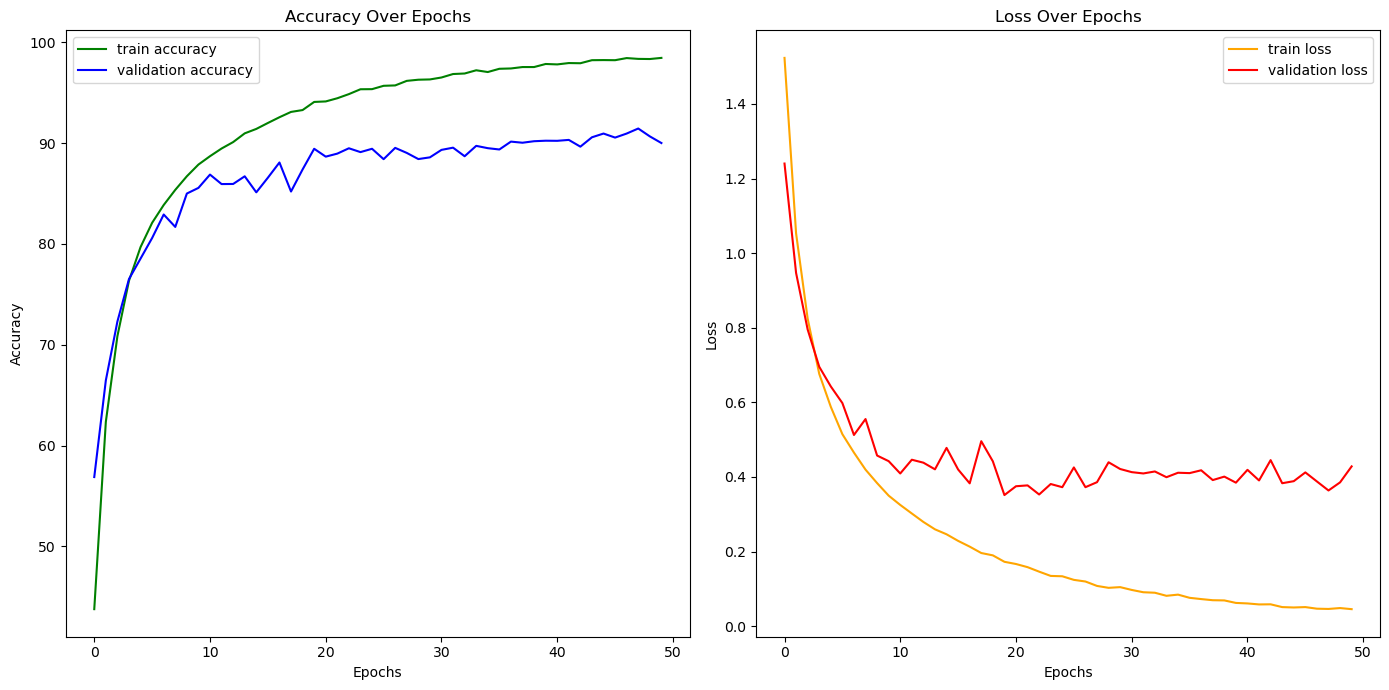


Training loss::[1.5235006941858764, 1.0530989551940537, 0.8244970571202086, 0.6764170451618522, 0.5879579109456533, 0.5146103782955643, 0.46522580938952046, 0.4195623173547523, 0.3834956146567069, 0.3498279657548346, 0.32491257065511725, 0.3019965503202832, 0.2792709436258087, 0.25953515991092185, 0.24624354856284073, 0.2285503113447019, 0.2131352027463715, 0.19598917204819982, 0.18974267651834298, 0.17248465039807817, 0.16655059388893492, 0.1581081046968165, 0.14604984011853595, 0.13461590613312352, 0.13366382579793176, 0.12403816932245441, 0.11963947663379028, 0.10778875666958711, 0.10265968316782485, 0.10455780910790119, 0.09701376158596418, 0.09083948691811441, 0.08954230891993208, 0.08128049654369254, 0.08446522784012053, 0.0759042029779957, 0.0725178930591649, 0.06946370571427753, 0.06891970874567795, 0.06221586520410836, 0.06084304614751207, 0.058175639182988965, 0.05848539561269057, 0.05101940229408862, 0.049998278372034986, 0.05103491852893625, 0.046752532301268176, 0.0460615

<Figure size 2500x400 with 0 Axes>

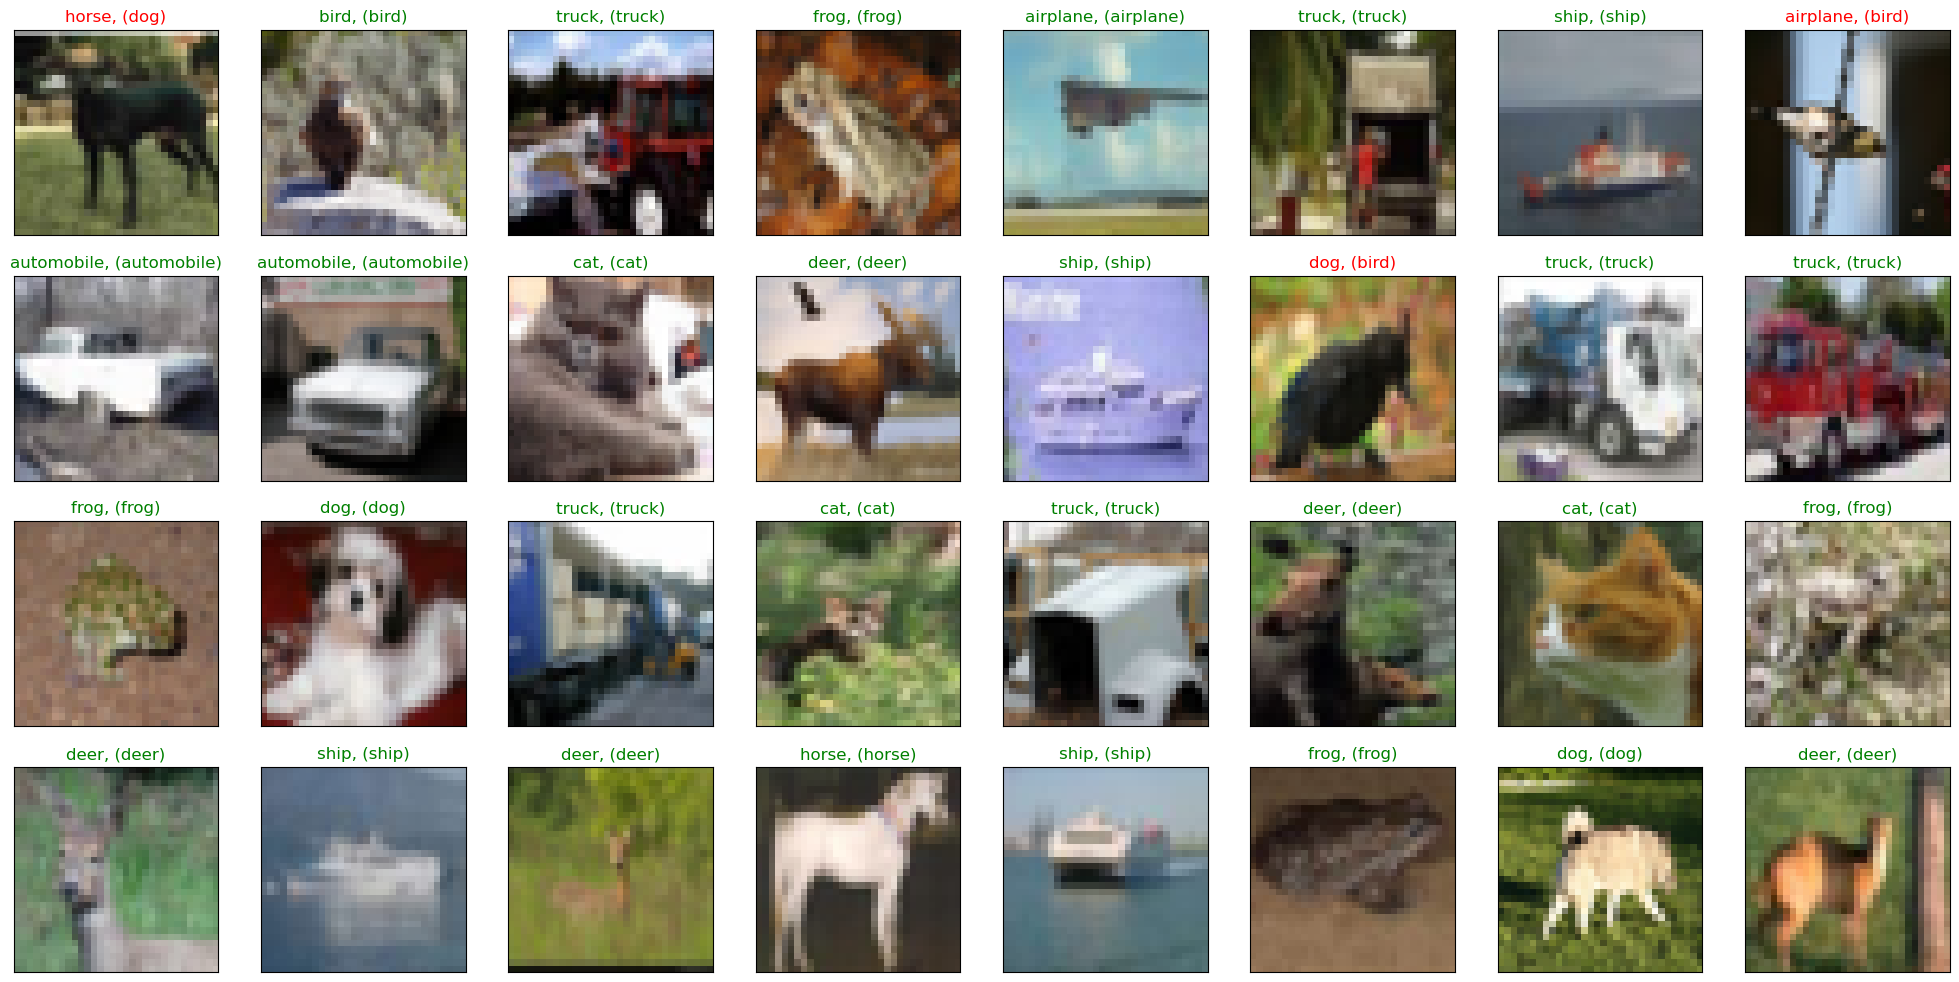

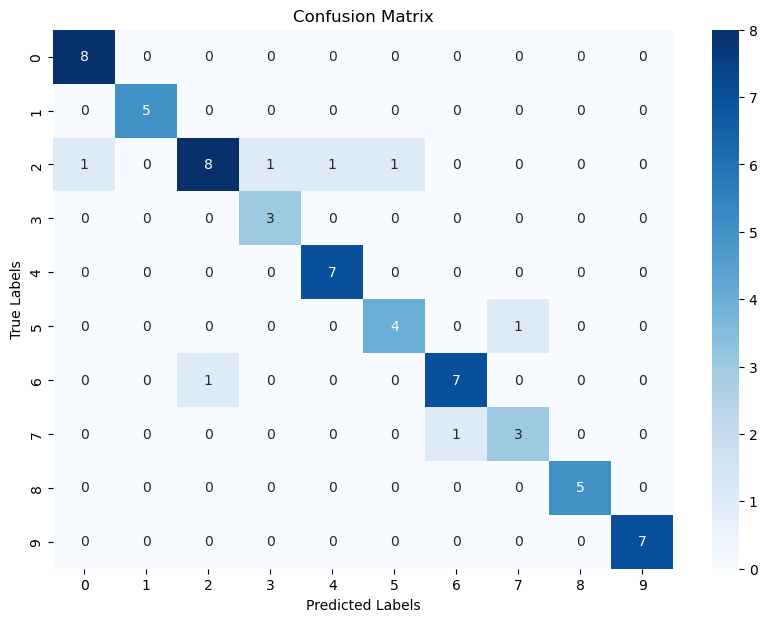

In [20]:
#implementation for original version of resnet-34 model
epochs=50
training_loss, validation_loss, training_acc, validation_acc= train_validate(net,optimizer_sgd,scheduler_sgd)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net)
print("\n")
print_image(net)

### 8. Implemeting modified model

[INFO]: Epoch 1 of 50
Training loss: 1.536, training acc: 43.316, Validation loss: 1.295, validation acc: 54.360, Learning rate: 0.001 Time: 00:00:59
--------------------------------------------------
[INFO]: Epoch 2 of 50
Training loss: 1.087, training acc: 61.226, Validation loss: 1.074, validation acc: 63.210, Learning rate: 0.001 Time: 00:01:04
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training loss: 0.871, training acc: 69.290, Validation loss: 0.766, validation acc: 73.120, Learning rate: 0.001 Time: 00:01:04
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training loss: 0.717, training acc: 75.060, Validation loss: 0.722, validation acc: 75.550, Learning rate: 0.001 Time: 00:01:04
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training loss: 0.617, training acc: 78.602, Validation loss: 0.588, validation acc: 79.700, Learning rate: 0.001 Time: 00:01:04
----------------------------------------------

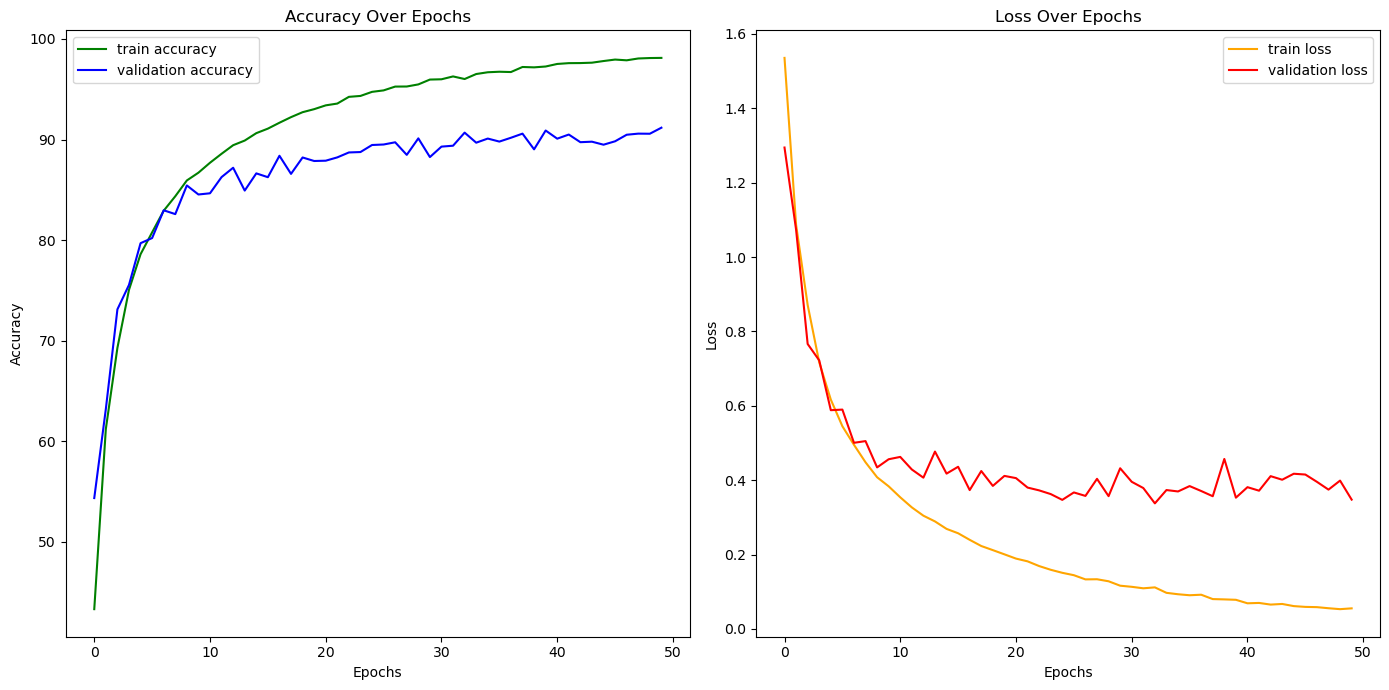


Training loss::[1.5357110570458805, 1.0868795197028334, 0.8712792213615554, 0.717020804505519, 0.616805213682182, 0.5451412461221675, 0.49525158640826145, 0.44815242484859796, 0.4079307553065402, 0.383483763669839, 0.3539884150542719, 0.3268801792026938, 0.3045576352654668, 0.2891459089258443, 0.2690626477722622, 0.25729283494184085, 0.23962006135784147, 0.2230021997981364, 0.21193524480075634, 0.20062120371710157, 0.1891613275508213, 0.1817749431023322, 0.1690736699663579, 0.15908661986346287, 0.15094899805858158, 0.14450873802308842, 0.13324922327037966, 0.13362128029117729, 0.1281540848510078, 0.11629645688378293, 0.11327944238624914, 0.10928068383861228, 0.11176643738061037, 0.0970855850233313, 0.09327366582268035, 0.09059787672155958, 0.0920174656372727, 0.08026535187126196, 0.07943378731279689, 0.07835260575251354, 0.06895512752199208, 0.06991476965639407, 0.06545697494059839, 0.06718059909313231, 0.06138905192918294, 0.05927797032030695, 0.05860381563017836, 0.05567312565491632

<Figure size 2500x400 with 0 Axes>

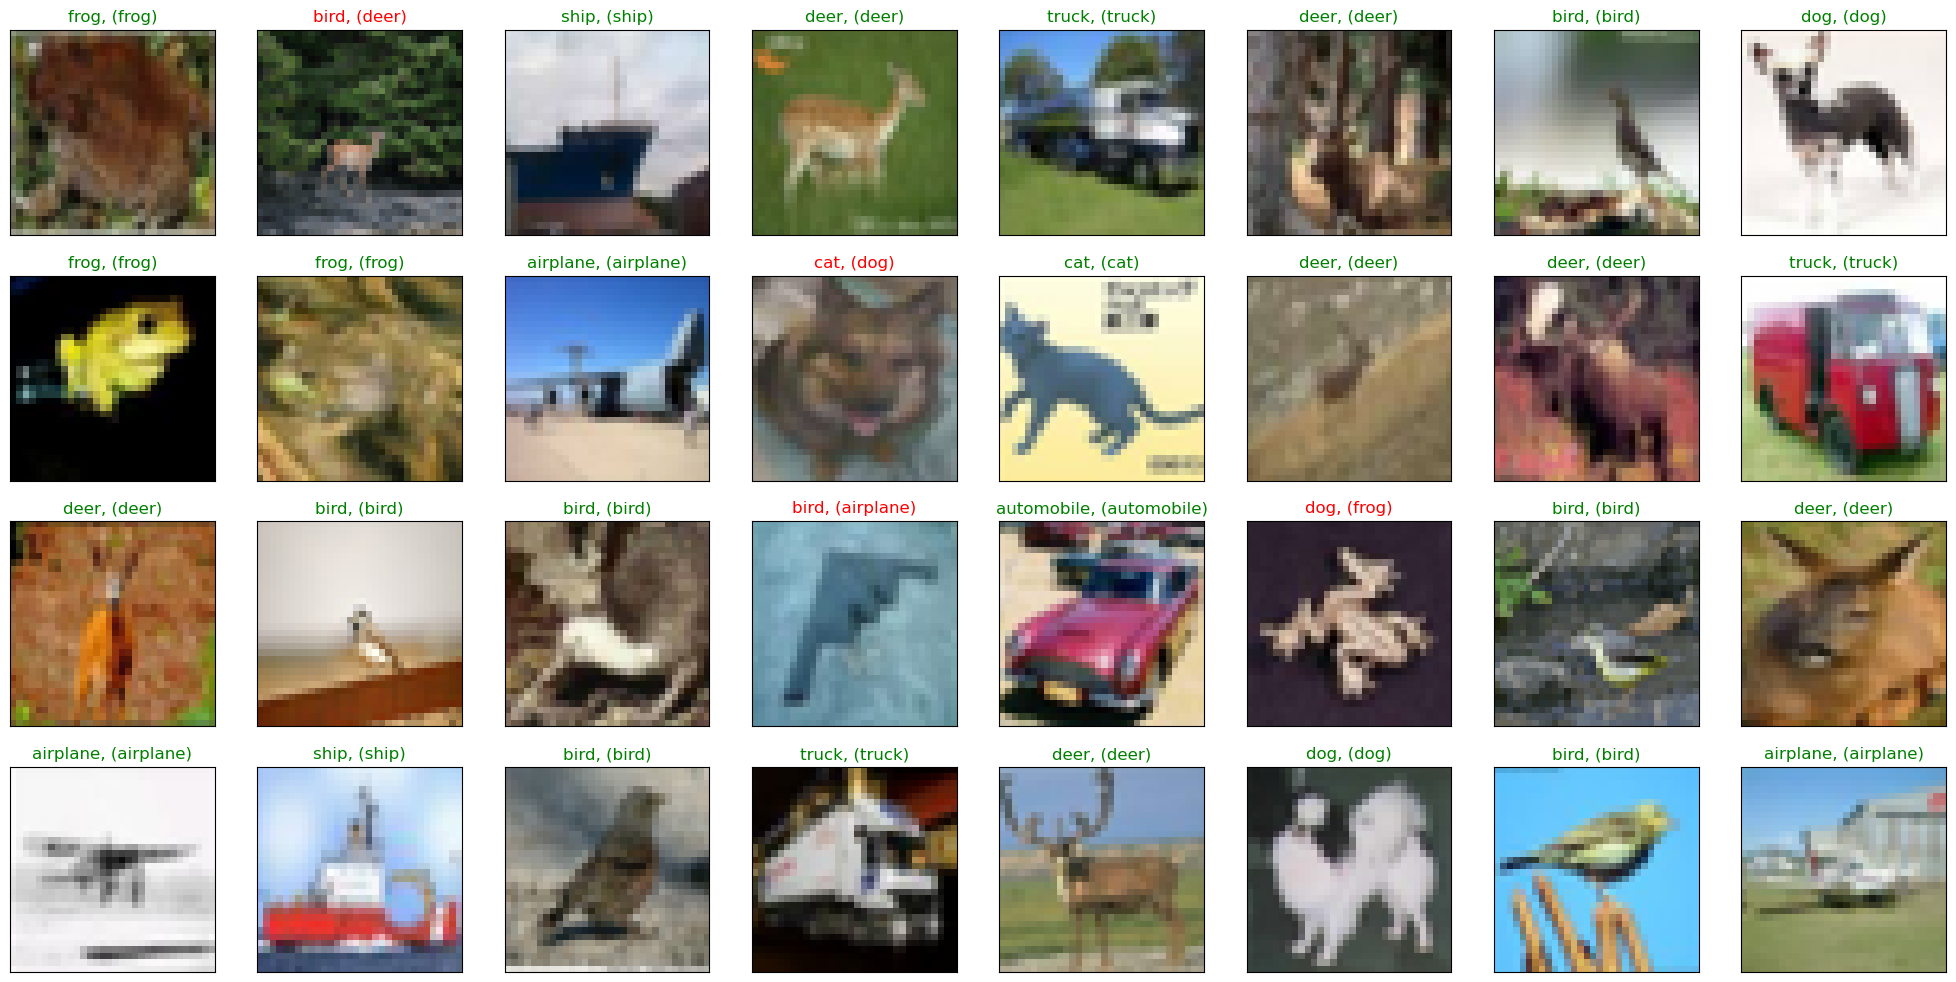

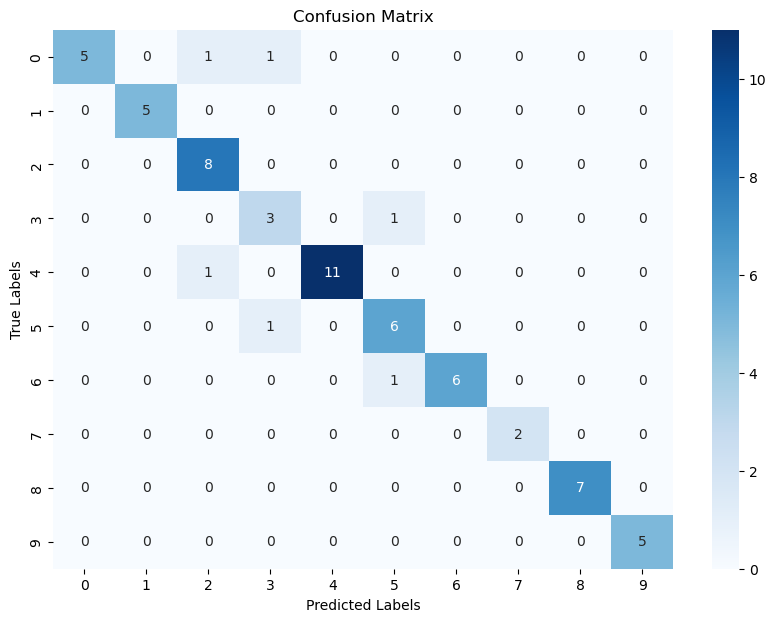

In [21]:
#implementation for modified version of resnet-34 model
epochs = 50
training_loss, validation_loss, training_acc, validation_acc=train_validate(net_modify,optimizer_sgd_modify,scheduler_sgd_modify)
print("\n")
plot_loss_Acc(training_loss, validation_loss, training_acc, validation_acc)
print("\n")
test_model(net_modify)
print("\n")
print_image(net_modify)


### 9. Save the model


In [22]:
torch.save(net,save_path[:-4]+str(epochs+1)+'.pth')